In [1]:
from core.runner import Runner
import tensorflow as tf

grid_length = 8

runner = Runner(
    grid_length=grid_length,
    main_layer_hidden_nodes=(30, 20),
    branch1_hidden_nodes=(),
    branch2_hidden_nodes=(),
    activation="swish",
    exploration_rate=0.01,
    learning_rate=0.01,
    environment_mode="spinfoam_vertex"
)

2023-01-20 14:04:22.459303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(0.0, 10.0)

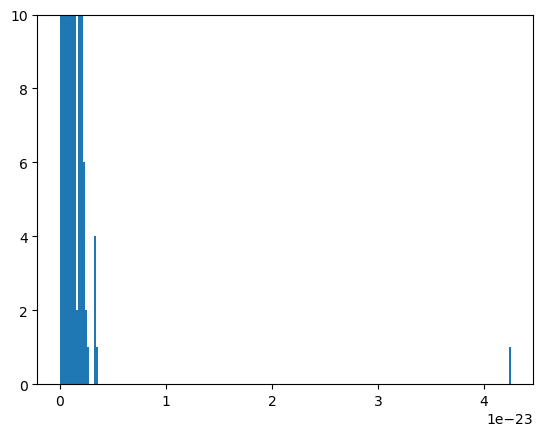

In [2]:
import matplotlib.pyplot as plt

sq_a = runner.env.squared_amplitudes.numpy().ravel()
rewards = runner.env.rewards.numpy().ravel()

plt.hist(sq_a, bins=200);
plt.ylim(0, 10)

(0.0, 10.0)

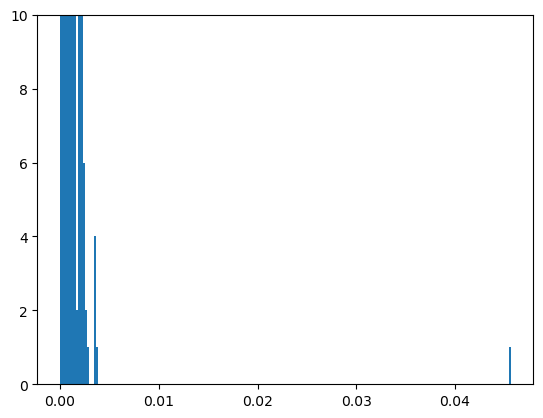

In [3]:
plt.hist(rewards, bins=200);
plt.ylim(0, 10)

In [3]:
import time

half_batch_size = tf.constant(500)
n_iterations = tf.constant(int(2e3))
# n_iterations = tf.constant(500)
evaluate_every_n_iterations = tf.constant(int(1e2))
evaluation_batch_size = tf.constant(int(5e4))

start = time.time()
ave_losses, ave_distr_errors, agent_obs = runner.train_agent(
    half_batch_size, n_iterations, evaluate_every_n_iterations, evaluation_batch_size
)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")
print(f"Average loss of last iteration: {float(ave_losses[-1])}")

Iteration: 0 Average Loss: 24.7875977
Iteration: 100 Average Loss: 7.34312201
Iteration: 200 Average Loss: 5.51297188
Iteration: 300 Average Loss: 3.9515698
Iteration: 400 Average Loss: 3.99993372
Iteration: 500 Average Loss: 3.39251661
Iteration: 600 Average Loss: 2.89663029
Iteration: 700 Average Loss: 2.66725802
Iteration: 800 Average Loss: 2.75563431
Iteration: 900 Average Loss: 2.79340911
Iteration: 1000 Average Loss: 3.15643024
Iteration: 1100 Average Loss: 3.20910263
Iteration: 1200 Average Loss: 3.01282525
Iteration: 1300 Average Loss: 2.94580626
Iteration: 1400 Average Loss: 3.10100198
Iteration: 1500 Average Loss: 2.68993187
Iteration: 1600 Average Loss: 2.51656222
Iteration: 1700 Average Loss: 2.84197402
Iteration: 1800 Average Loss: 2.69454932
Iteration: 1900 Average Loss: 2.47098184
Time Elapsed: 307.6863360404968 s
Average loss of last iteration: 2.967830181121826


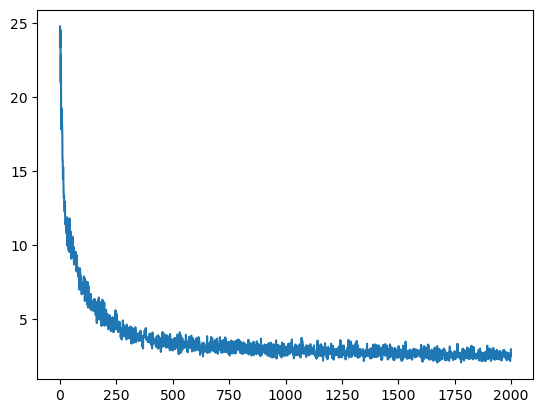

In [4]:
# import matplotlib.pyplot as plt

plt.plot(ave_losses.numpy())

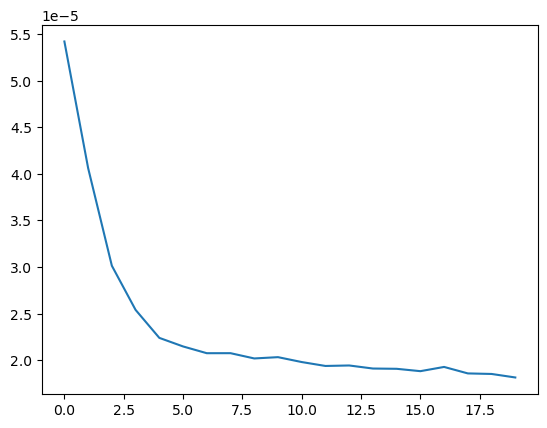

In [5]:
plt.plot(ave_distr_errors.numpy())
# ave_distr_errors

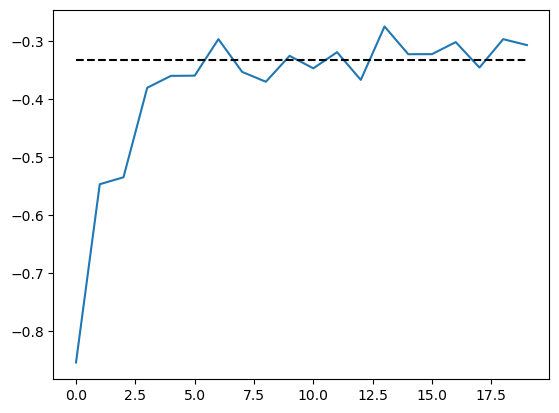

In [6]:
plt.plot(agent_obs.numpy())
plt.hlines(
    runner.env.theoretical_ave_dihedral_angle.numpy(),
    0, len(agent_obs) - 1, linestyles='dashed', colors='k'
)

In [8]:
runner.env.theoretical_ave_dihedral_angle.numpy()

-0.33333334

In [10]:
env_distr = runner.env.rewards / tf.math.reduce_sum(runner.env.rewards)

In [19]:
import numpy as np

def _plot_l1_errors_per_probability_interval(agent_prob, env_prob, 
#                                              filename, 
                                             n_intervals
                                            ):
    result = agent_prob.ravel()
    expected = env_prob.ravel()
    max_expected = expected.max()
    expected_pcts = expected * 100 / max_expected

    interval_edges = np.linspace(0, 100, n_intervals + 1)
    starts = interval_edges[:-1]
    ends = interval_edges[1:]

#     frac_l1_errors = np.abs(result - expected) / max_expected
    l1_errors = np.abs(result - expected)
    errors = []
    labels = []
    for s, e in zip(starts, ends):
        inds = np.where((s < expected_pcts) & (expected_pcts <= e))
#         errors_per_interval = frac_l1_errors[inds]
        errors_per_interval = l1_errors[inds]
        if len(errors_per_interval):
            interval_label = f"{s:.2f}% < pct <= {e:.2f}%"
            max_expected_per_interval = expected[inds].max()
            errors.append(errors_per_interval / max_expected_per_interval)
            labels.append(interval_label)

#     print(errors)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.violinplot(errors)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels, rotation=15)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Fractional L1 Errors")
    ax.set_xlabel("Percentage of max theoretical probability")
    plt.tight_layout()
#     fig.savefig(f"./plot_results/{filename}")
    return errors

In [20]:
batch_size = tf.constant(int(5e4))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

grid_dim = 5
n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 26.92%


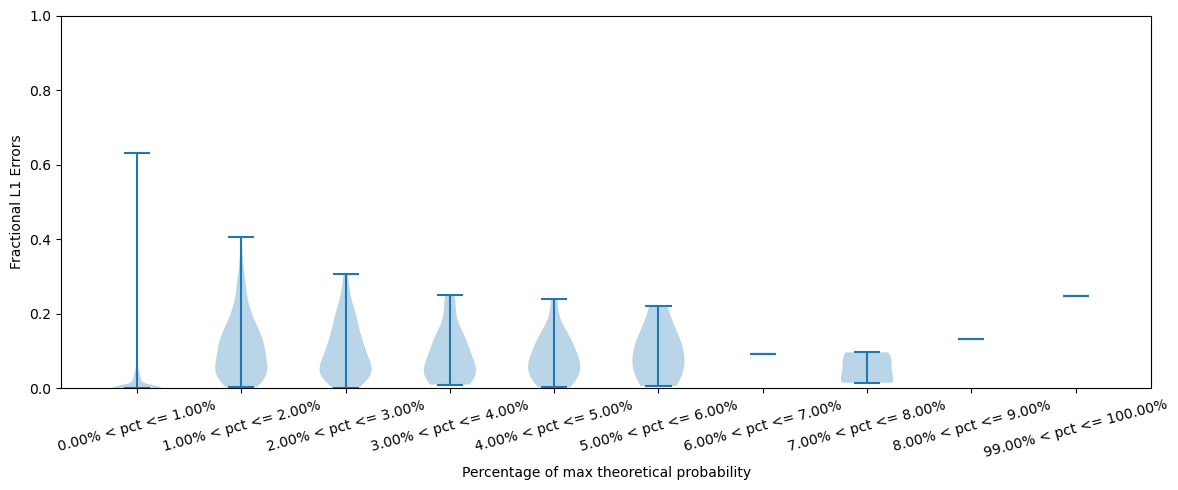

In [21]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=100
)

In [22]:
batch_size = tf.constant(int(1e5))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

grid_dim = 5
n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 34.56%


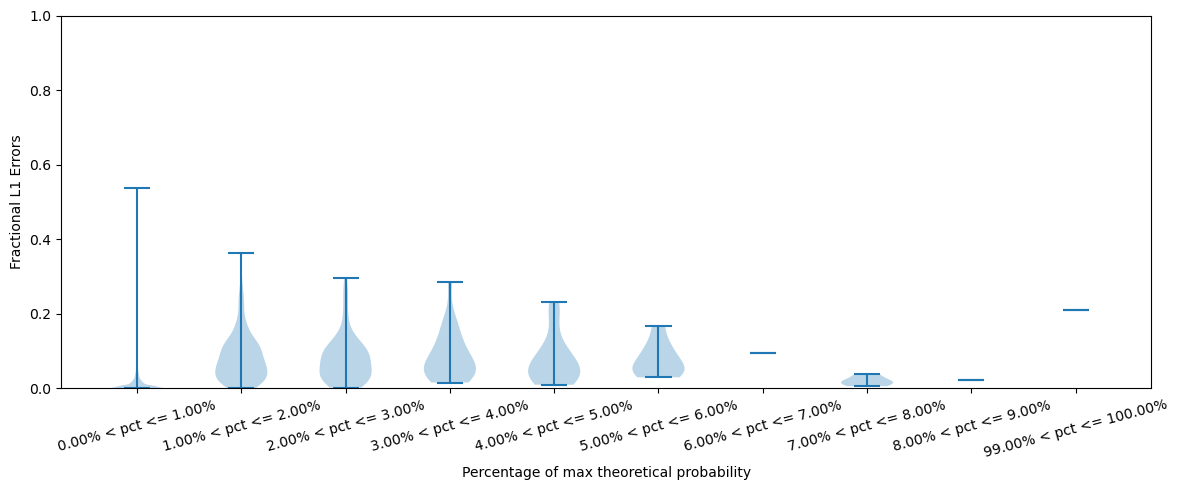

In [23]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=100
)

In [24]:
batch_size = tf.constant(int(5e5))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

grid_dim = 5
n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 51.66%


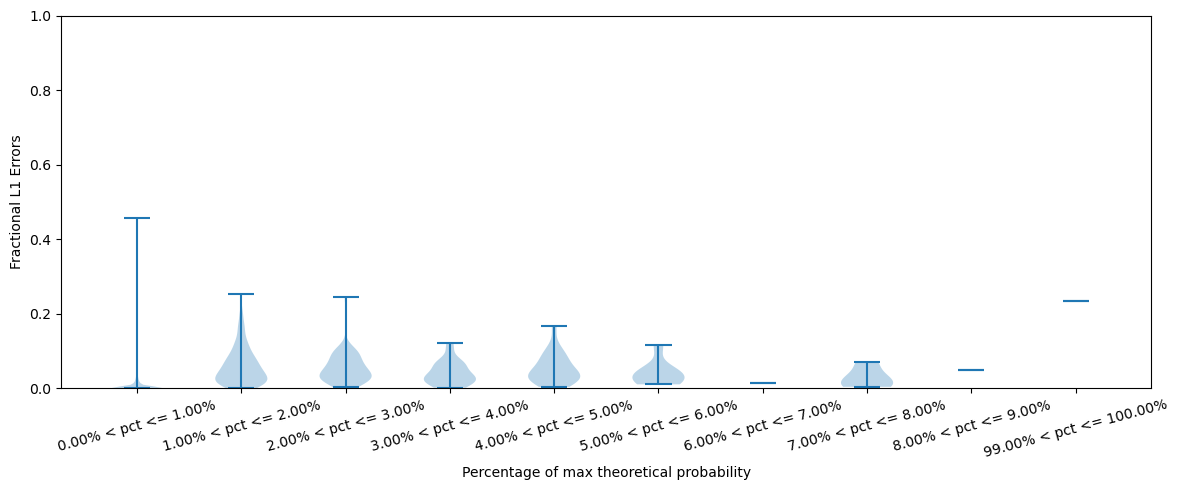

In [25]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=100
)